In [87]:
import matplotlib.pyplot as plt
import numpy as np
import cv2 as cv
import os

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=DeprecationWarning)

In [2]:
ROOT = os.getcwd()
ROOT

'c:\\Users\\dell-2019\\Desktop\\Sign Language Detection'

In [248]:
TOP = 100
BOTTOM = 300
RIGHT = 150
LEFT = 350

Testing the image contouring
[Code reference](https://stackoverflow.com/a/65794671/13280114)

In [49]:
def segment_hand_simple(img):
    # define the upper and lower boundaries of the HSV pixel intensities 
    # to be considered 'skin'
    hsvim = cv.cvtColor(img, cv.COLOR_BGR2HSV)
    lower = np.array([0, 48, 80], dtype="uint8")
    upper = np.array([20, 255, 255], dtype="uint8")
    skinMask= cv.inRange(hsvim, lower, upper)

    # blur the mask to help remove noise
    skinMask= cv.blur(skinMask, (2, 2))

    # get threshold image
    ret, thresh = cv.threshold(skinMask, 100, 255, cv.THRESH_BINARY)
    return thresh

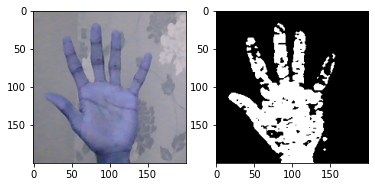

In [50]:
img_path = "images/train/0.png"
img = cv.imread(img_path)

thresh = segment_hand_simple(img)

fig, ax = plt.subplots(1, 2)
ax[0].imshow(img)
ax[1].imshow(thresh)
plt.imshow(thresh, cmap='gray')

In [9]:
def chdir(path):
    if os.path.exists(f'images/{path}'):
        print('Directory changed to images')
    else:
        print('Directory not found')
        os.mkdir(f'images/{path}')
    os.chdir(f'images/{path}')

In [53]:
# change directory to the folder where the images are
if os.getcwd() == ROOT:
    chdir("train/a")
else: 
    os.chdir(ROOT)
    chdir("train")

cam = cv.VideoCapture(0)
img_counter = 0

while True:
    ret, frame = cam.read()
    # filpping the frame to prevent inverted image of captured frame
    frame = cv.flip(frame, 1)
    
    if not ret:
        print("Please check if the camera is connected properly or is being used by another program")
        break

    cv.imshow("Frame", frame)

    frame_copy = frame.copy()
    roi = frame[TOP:BOTTOM, RIGHT:LEFT]

    k = cv.waitKey(1)
    if k%256 == 27:
        break
    elif k%256 == 32: # SPACE pressed
        hand = segment_hand_simple(roi)
        img_name = "{}.png".format(img_counter)

        # get current working directory
        path = os.getcwd()
        cv.imwrite(os.path.join(path , img_name), hand)
        img_counter += 1

    # Drawing ROI on frame copy
    cv.rectangle(frame_copy, (LEFT, TOP), (RIGHT, BOTTOM), (255,128,0), 3)

    # Display the frame with segmented hand
    cv.imshow("Hand Region", roi)

cam.release()
cv.destroyAllWindows()
# change directory to the root directory
os.chdir(ROOT)

Directory changed to images
Escape hit, closing...


Load the images using Keras ImageDataGenerator

In [175]:
from keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf

train_path = os.path.join(ROOT, "images/train")
test_path = os.path.join(ROOT, "images/test")

# params = {
#     'rescale':1./255,
#     'shear_range':0.2,
#     'zoom_range':0.2,
#     'horizontal_flip':True,
    
# }

train_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input)

train_data = train_batches.flow_from_directory(
    directory=train_path, 
    target_size=(64,64), 
    class_mode='categorical', 
    batch_size=3,
)

Found 39 images belonging to 3 classes.


In [198]:
train_data.image_shape, train_data.class_indices

((64, 64, 3), {'A': 0, 'B': 1, 'C': 2})

In [ ]:
# plot the images

# MODEL CREATION

In [229]:
from keras.models import Sequential
from tensorflow import keras
from keras.layers import Dense, Flatten, Conv2D, MaxPool2D, Dropout

In [236]:
INPUT_SHAPE = (64, 64, 3)
OUTPUT_SHAPE = 3

In [237]:
model_params = [
    keras.layers.Conv2D(filters=8, kernel_size=(3,3),strides=(1,1),padding='same',input_shape=INPUT_SHAPE,activation='relu', data_format='channels_last'),
    keras.layers.MaxPool2D(pool_size=(2,2)),
    keras.layers.Conv2D(filters=16, kernel_size=(3,3),strides=(1,1),padding='same',activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.MaxPool2D(pool_size=(4,4)),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Flatten(),
    keras.layers.Dense(OUTPUT_SHAPE, activation='softmax')
]

params = {
    'loss': 'categorical_crossentropy',
    'optimizer': 'SGD',
    'metrics': ['accuracy']
}

In [239]:
model = Sequential(model_params)

# compile the model with params
model.compile(**params)

In [240]:
model.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_36 (Conv2D)          (None, 64, 64, 8)         224       
                                                                 
 max_pooling2d_29 (MaxPoolin  (None, 32, 32, 8)        0         
 g2D)                                                            
                                                                 
 conv2d_37 (Conv2D)          (None, 32, 32, 16)        1168      
                                                                 
 dropout_9 (Dropout)         (None, 32, 32, 16)        0         
                                                                 
 max_pooling2d_30 (MaxPoolin  (None, 8, 8, 16)         0         
 g2D)                                                            
                                                                 
 dense_31 (Dense)            (None, 8, 8, 128)       

In [241]:
history = model.fit(train_data, epochs=10)

Epoch 1/10
13/13 [==============================] - 4s 17ms/step - loss: 320598.2188 - accuracy: 0.2308
Epoch 2/10
13/13 [==============================] - 0s 18ms/step - loss: 1.0998 - accuracy: 0.3333
Epoch 3/10
13/13 [==============================] - 0s 19ms/step - loss: 1.0996 - accuracy: 0.3333
Epoch 4/10
13/13 [==============================] - 0s 19ms/step - loss: 1.0992 - accuracy: 0.2821
Epoch 5/10
13/13 [==============================] - 0s 15ms/step - loss: 1.0999 - accuracy: 0.2564
Epoch 6/10
13/13 [==============================] - 0s 17ms/step - loss: 1.0997 - accuracy: 0.3333
Epoch 7/10
13/13 [==============================] - 0s 15ms/step - loss: 1.0995 - accuracy: 0.3077
Epoch 8/10
13/13 [==============================] - 0s 20ms/step - loss: 1.0994 - accuracy: 0.3077
Epoch 9/10
13/13 [==============================] - 0s 16ms/step - loss: 1.0996 - accuracy: 0.3077
Epoch 10/10
13/13 [==============================] - 0s 14ms/step - loss: 1.0998 - accuracy: 0.2821


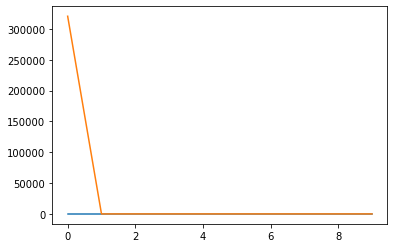

In [242]:
# plot the training loss and accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['loss'])

In [243]:
# load the test data
test_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input)
test_data = test_batches.flow_from_directory(
    directory=test_path,
    target_size=(64,64),
    class_mode='categorical',
    batch_size=3,
    shuffle=False
)

imgs, labels = next(test_data)

Found 39 images belonging to 3 classes.


In [244]:
scores = model.evaluate(imgs, labels, verbose=0)
print(f'{model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%')

loss of 1.0982789993286133; accuracy of 0.0%


In [245]:
predictions = model.predict(imgs)
predictions

array([[0.33344448, 0.33208048, 0.334475  ],
       [0.33344448, 0.33208048, 0.334475  ],
       [0.33344448, 0.33208048, 0.334475  ]], dtype=float32)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, '2-0')

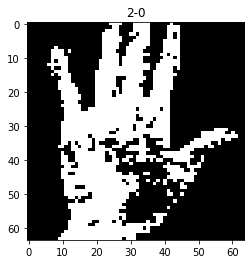

In [246]:
plt.imshow(imgs[1])
plt.title(f"{predictions[1].argmax()}-{labels[1].argmax()}")